# PreTrain

In [1]:
from model.sswae_dev2_2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8
rm = [1,8]

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10 - len(rm) + 1),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [i for i in range(10) if i not in rm]
print("lab:", labeled_class, "rm:", rm)
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

lab: [0, 2, 3, 4, 5, 6, 7, 9] rm: [1, 8]


In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.171
[2] loss: 0.126
[3] loss: 0.041
[4] loss: 0.024
[5] loss: 0.015
[6] loss: 0.012
[7] loss: 0.011
[8] loss: 0.007
[9] loss: 0.007
[10] loss: 0.007
[11] loss: 0.005
[12] loss: 0.006
[13] loss: 0.003
[14] loss: 0.005
[15] loss: 0.004
[16] loss: 0.003
[17] loss: 0.004
[18] loss: 0.003
[19] loss: 0.001
[20] loss: 0.005


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

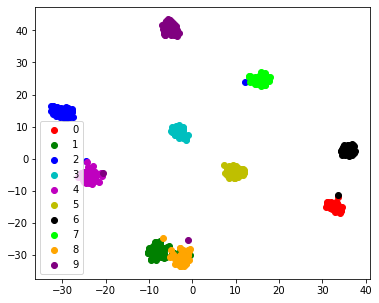

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

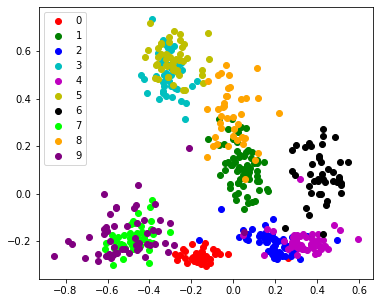

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, class_no = True, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10 - len(rm) + 1, y_dim))
cs = np.zeros(10 - len(rm) + 1)
covs = np.zeros((10 - len(rm) + 1, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10 - len(rm) + 1, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10 - len(rm)):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.1450,  0.1720, -0.3224,  0.3386, -0.2606,  0.4271, -0.4665, -0.5126,
          0.0189],
        [-0.1413,  0.4906,  0.4220, -0.2491, -0.1749, -0.2342,  0.2837, -0.1076,
         -0.2016],
        [-0.2446, -0.1970,  0.5035, -0.2121,  0.5395,  0.1011, -0.2016, -0.1884,
          0.1981],
        [-0.2344, -0.2401, -0.3469,  0.3823,  0.2669, -0.3199,  0.1652,  0.3151,
         -0.1577],
        [-0.1007, -0.0748, -0.0774, -0.1542, -0.1321, -0.1197,  0.5593, -0.1768,
          0.4453],
        [-0.0751, -0.2037,  0.4691, -0.1683, -0.1338,  0.4777,  0.0038,  0.6184,
         -0.1533],
        [ 0.4327, -0.3221,  0.1977, -0.3190,  0.3025, -0.0817, -0.1268, -0.2168,
         -0.3125],
        [ 0.5690,  0.1852, -0.1022, -0.1056, -0.1812, -0.0976, -0.1386,  0.5574,
          0.4602]])

In [13]:
f1 = nn.Linear(10 - len(rm) + 1, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)
w2.shape

torch.Size([9, 8, 8])

In [15]:
for i in range(10 - len(rm) + 1):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10 - len(rm) + 1, 1, y_dim, bias=False)
f2.weight.data = w2.view(10 - len(rm) + 1, 1, y_dim, y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

# Train

In [17]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_rm_4,9_unk.cfg')

['./config/sswae_dev2_rm_4,9_unk.cfg']

In [18]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,5,6,7,8
[default |INFO|_base_model.py:29] unlabeled_class : 4,9
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] unk : True
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_ba

[default |INFO|model.py:1823] [01/80]  loss: 2.505598e-01  D: 6.951785e-01  D2: 5.412076e-02  D3: 3.874983e-03
test loss: 1.947043e-01  D: 6.864318e-01  D2: 2.909693e-02  D3: 6.042662e-03


[default |INFO|model.py:1823] [02/80]  loss: 1.843796e-01  D: 6.937620e-01  D2: 2.012451e-02  D3: 8.070366e-03
test loss: 1.734339e-01  D: 6.450428e-01  D2: 8.043127e-03  D3: 1.201840e-02


[default |INFO|model.py:1823] [03/80]  loss: 1.635365e-01  D: 7.025437e-01  D2: 4.863396e-03  D3: 1.250513e-02
test loss: 1.481424e-01  D: 7.150836e-01  D2: 2.302027e-03  D3: 1.395854e-02


[default |INFO|model.py:1823] [04/80]  loss: 1.406718e-01  D: 6.970089e-01  D2: 1.830632e-03  D3: 1.469420e-02
test loss: 1.252033e-01  D: 7.043870e-01  D2: 1.092196e-03  D3: 1.478049e-02


[default |INFO|model.py:1823] [05/80]  loss: 1.098504e-01  D: 6.942187e-01  D2: 7.707469e-04  D3: 1.358000e-02
test loss: 9.732681e-02  D: 6.973493e-01  D2: -1.056442e-03  D3: 1.345689e-02


[default |INFO|model.py:1823] [06/80]  loss: 9.410457e-02  D: 6.936672e-01  D2: -2.076885e-03  D3: 1.539566e-02
test loss: 8.911460e-02  D: 6.987453e-01  D2: -3.469934e-03  D3: 1.565586e-02


[default |INFO|model.py:1823] [07/80]  loss: 8.478066e-02  D: 6.933608e-01  D2: -3.573273e-03  D3: 1.511388e-02
test loss: 8.077062e-02  D: 6.865298e-01  D2: -3.337250e-03  D3: 1.477372e-02


[default |INFO|model.py:1823] [08/80]  loss: 7.986513e-02  D: 6.939782e-01  D2: -4.052145e-03  D3: 1.464259e-02
test loss: 7.534481e-02  D: 6.884843e-01  D2: -3.958588e-03  D3: 1.458250e-02


[default |INFO|model.py:1823] [09/80]  loss: 7.605827e-02  D: 6.937127e-01  D2: -4.233502e-03  D3: 1.451256e-02
test loss: 7.525587e-02  D: 6.907258e-01  D2: -4.779987e-03  D3: 1.519387e-02


[default |INFO|model.py:1823] [10/80]  loss: 7.280869e-02  D: 6.937232e-01  D2: -4.391712e-03  D3: 1.491208e-02
test loss: 7.044532e-02  D: 6.807981e-01  D2: -4.668255e-03  D3: 1.411728e-02


[default |INFO|model.py:1823] [11/80]  loss: 6.951526e-02  D: 6.930662e-01  D2: -4.717525e-03  D3: 1.461694e-02
test loss: 6.753652e-02  D: 6.860430e-01  D2: -5.306416e-03  D3: 1.432772e-02


[default |INFO|model.py:1823] [12/80]  loss: 6.922215e-02  D: 6.938246e-01  D2: -5.069766e-03  D3: 1.407675e-02
test loss: 6.752746e-02  D: 6.805048e-01  D2: -5.143442e-03  D3: 1.405065e-02


[default |INFO|model.py:1823] [13/80]  loss: 6.653516e-02  D: 6.934082e-01  D2: -5.453684e-03  D3: 1.427112e-02
test loss: 6.520354e-02  D: 6.826338e-01  D2: -5.383091e-03  D3: 1.558718e-02


[default |INFO|model.py:1823] [14/80]  loss: 6.534664e-02  D: 6.938696e-01  D2: -5.652019e-03  D3: 1.437681e-02
test loss: 6.425671e-02  D: 7.054695e-01  D2: -6.084156e-03  D3: 1.331599e-02


[default |INFO|model.py:1823] [15/80]  loss: 6.556693e-02  D: 6.935751e-01  D2: -5.434314e-03  D3: 1.375377e-02
test loss: 6.513111e-02  D: 6.974141e-01  D2: -6.130371e-03  D3: 1.248615e-02


[default |INFO|model.py:1823] [16/80]  loss: 6.346542e-02  D: 6.937714e-01  D2: -5.722713e-03  D3: 1.405708e-02
test loss: 6.195320e-02  D: 6.957800e-01  D2: -5.833168e-03  D3: 1.579014e-02


[default |INFO|model.py:1823] [17/80]  loss: 6.161451e-02  D: 6.934999e-01  D2: -5.890938e-03  D3: 1.410887e-02
test loss: 5.946147e-02  D: 7.022070e-01  D2: -6.654463e-03  D3: 1.348510e-02


[default |INFO|model.py:1823] [18/80]  loss: 6.050006e-02  D: 6.932758e-01  D2: -5.822563e-03  D3: 1.396816e-02
test loss: 6.179856e-02  D: 6.873366e-01  D2: -6.307497e-03  D3: 1.275917e-02


[default |INFO|model.py:1823] [19/80]  loss: 5.981357e-02  D: 6.936042e-01  D2: -6.364161e-03  D3: 1.388986e-02
test loss: 6.066018e-02  D: 6.922045e-01  D2: -6.290960e-03  D3: 1.455364e-02


[default |INFO|model.py:1823] [20/80]  loss: 5.947216e-02  D: 6.937528e-01  D2: -6.284747e-03  D3: 1.363366e-02
test loss: 6.204488e-02  D: 7.064737e-01  D2: -6.088305e-03  D3: 1.445244e-02


[default |INFO|model.py:1823] [21/80]  loss: 5.953765e-02  D: 6.936060e-01  D2: -6.477294e-03  D3: 1.345104e-02
test loss: 5.992146e-02  D: 6.940668e-01  D2: -7.017870e-03  D3: 1.277069e-02


[default |INFO|model.py:1823] [22/80]  loss: 5.823377e-02  D: 6.938356e-01  D2: -6.544309e-03  D3: 1.367463e-02
test loss: 5.747157e-02  D: 6.906764e-01  D2: -6.898022e-03  D3: 1.231725e-02


[default |INFO|model.py:1823] [23/80]  loss: 5.835238e-02  D: 6.933551e-01  D2: -6.862548e-03  D3: 1.352030e-02
test loss: 5.858401e-02  D: 6.878785e-01  D2: -6.732264e-03  D3: 1.348319e-02


[default |INFO|model.py:1823] [24/80]  loss: 5.861588e-02  D: 6.939074e-01  D2: -6.860094e-03  D3: 1.306919e-02
test loss: 6.030758e-02  D: 7.147742e-01  D2: -6.738586e-03  D3: 1.358155e-02


[default |INFO|model.py:1823] [25/80]  loss: 5.815530e-02  D: 6.942155e-01  D2: -6.806459e-03  D3: 1.320996e-02
test loss: 5.829791e-02  D: 6.964705e-01  D2: -7.056952e-03  D3: 9.829938e-03


[default |INFO|model.py:1823] [26/80]  loss: 5.749126e-02  D: 6.940750e-01  D2: -7.091726e-03  D3: 1.309020e-02
test loss: 5.753594e-02  D: 6.902715e-01  D2: -7.298460e-03  D3: 1.451010e-02


[default |INFO|model.py:1823] [27/80]  loss: 5.775912e-02  D: 6.932396e-01  D2: -7.093817e-03  D3: 1.328319e-02
test loss: 5.732883e-02  D: 6.913791e-01  D2: -7.469501e-03  D3: 1.334338e-02


[default |INFO|model.py:1823] [28/80]  loss: 5.580568e-02  D: 6.935496e-01  D2: -7.420721e-03  D3: 1.341920e-02
test loss: 5.736669e-02  D: 6.943472e-01  D2: -7.643547e-03  D3: 1.390260e-02


[default |INFO|model.py:1823] [29/80]  loss: 5.643620e-02  D: 6.937256e-01  D2: -7.510320e-03  D3: 1.314980e-02
test loss: 5.706370e-02  D: 7.078446e-01  D2: -7.579956e-03  D3: 1.300511e-02


[default |INFO|model.py:1823] [30/80]  loss: 5.514712e-02  D: 6.932535e-01  D2: -7.646616e-03  D3: 1.330982e-02
test loss: 5.561035e-02  D: 6.814560e-01  D2: -7.736197e-03  D3: 1.347838e-02


[default |INFO|model.py:1823] [31/80]  loss: 5.569899e-02  D: 6.935209e-01  D2: -7.759822e-03  D3: 1.298588e-02
test loss: 5.914931e-02  D: 7.127788e-01  D2: -7.267151e-03  D3: 1.688583e-02


[default |INFO|model.py:1823] [32/80]  loss: 5.568943e-02  D: 6.936715e-01  D2: -7.661125e-03  D3: 1.310137e-02
test loss: 5.654651e-02  D: 6.977067e-01  D2: -8.085546e-03  D3: 1.198563e-02


[default |INFO|model.py:1823] [33/80]  loss: 5.435987e-02  D: 6.939359e-01  D2: -7.970044e-03  D3: 1.312814e-02
test loss: 5.452911e-02  D: 6.918676e-01  D2: -8.010416e-03  D3: 1.290019e-02


[default |INFO|model.py:1823] [34/80]  loss: 5.370866e-02  D: 6.935505e-01  D2: -7.876531e-03  D3: 1.309163e-02
test loss: 5.569954e-02  D: 6.847840e-01  D2: -7.758436e-03  D3: 1.230359e-02


[default |INFO|model.py:1823] [35/80]  loss: 5.441075e-02  D: 6.932870e-01  D2: -8.002866e-03  D3: 1.295224e-02
test loss: 5.394397e-02  D: 6.934376e-01  D2: -8.226490e-03  D3: 1.377148e-02


[default |INFO|model.py:1823] [36/80]  loss: 5.337327e-02  D: 6.938262e-01  D2: -8.189251e-03  D3: 1.296106e-02
test loss: 5.536108e-02  D: 6.871386e-01  D2: -8.211470e-03  D3: 1.237703e-02


[default |INFO|model.py:1823] [37/80]  loss: 5.315520e-02  D: 6.937378e-01  D2: -8.232686e-03  D3: 1.296548e-02
test loss: 5.429505e-02  D: 6.962400e-01  D2: -8.502846e-03  D3: 1.374938e-02


[default |INFO|model.py:1823] [38/80]  loss: 5.335861e-02  D: 6.933061e-01  D2: -8.271456e-03  D3: 1.301026e-02
test loss: 5.652287e-02  D: 6.994191e-01  D2: -8.638411e-03  D3: 1.314794e-02


[default |INFO|model.py:1823] [39/80]  loss: 5.303675e-02  D: 6.940124e-01  D2: -8.483082e-03  D3: 1.277294e-02
test loss: 5.399970e-02  D: 6.837950e-01  D2: -8.364277e-03  D3: 1.188806e-02


[default |INFO|model.py:1823] [40/80]  loss: 5.301830e-02  D: 6.931683e-01  D2: -8.316722e-03  D3: 1.277656e-02
test loss: 5.667237e-02  D: 6.988513e-01  D2: -8.775759e-03  D3: 1.119114e-02


[default |INFO|model.py:1823] [41/80]  loss: 5.305193e-02  D: 6.934872e-01  D2: -8.451680e-03  D3: 1.278383e-02
test loss: 5.642667e-02  D: 6.906495e-01  D2: -8.226175e-03  D3: 1.287344e-02


[default |INFO|model.py:1823] [42/80]  loss: 5.171423e-02  D: 6.931381e-01  D2: -8.569864e-03  D3: 1.303059e-02
test loss: 5.349925e-02  D: 6.969817e-01  D2: -8.749409e-03  D3: 1.207719e-02


[default |INFO|model.py:1823] [43/80]  loss: 5.212466e-02  D: 6.931439e-01  D2: -8.580540e-03  D3: 1.281520e-02
test loss: 5.309901e-02  D: 6.971689e-01  D2: -8.364477e-03  D3: 1.285964e-02


[default |INFO|model.py:1823] [44/80]  loss: 5.218842e-02  D: 6.938488e-01  D2: -8.725953e-03  D3: 1.279422e-02
test loss: 5.372524e-02  D: 7.016702e-01  D2: -8.872957e-03  D3: 1.160105e-02


[default |INFO|model.py:1823] [45/80]  loss: 5.163742e-02  D: 6.928079e-01  D2: -8.903974e-03  D3: 1.274665e-02
test loss: 5.283440e-02  D: 6.939508e-01  D2: -9.031191e-03  D3: 1.277060e-02


[default |INFO|model.py:1823] [46/80]  loss: 5.192255e-02  D: 6.938310e-01  D2: -8.845911e-03  D3: 1.252673e-02
test loss: 5.536946e-02  D: 7.017301e-01  D2: -8.852692e-03  D3: 1.360809e-02


[default |INFO|model.py:1823] [47/80]  loss: 5.163785e-02  D: 6.933290e-01  D2: -8.862508e-03  D3: 1.261580e-02
test loss: 5.144155e-02  D: 6.933769e-01  D2: -8.989468e-03  D3: 1.265679e-02


[default |INFO|model.py:1823] [48/80]  loss: 5.068969e-02  D: 6.931828e-01  D2: -8.987471e-03  D3: 1.275547e-02
test loss: 5.291012e-02  D: 7.062611e-01  D2: -9.170866e-03  D3: 1.323783e-02


[default |INFO|model.py:1823] [49/80]  loss: 5.064597e-02  D: 6.934390e-01  D2: -9.016525e-03  D3: 1.270331e-02
test loss: 5.218177e-02  D: 6.923991e-01  D2: -9.245653e-03  D3: 1.242004e-02


[default |INFO|model.py:1823] [50/80]  loss: 5.030224e-02  D: 6.931813e-01  D2: -9.093081e-03  D3: 1.260236e-02
test loss: 5.209933e-02  D: 6.929493e-01  D2: -9.129324e-03  D3: 1.223062e-02


[default |INFO|model.py:1823] [51/80]  loss: 5.024473e-02  D: 6.930967e-01  D2: -9.141568e-03  D3: 1.267706e-02
test loss: 5.176538e-02  D: 6.894685e-01  D2: -9.202576e-03  D3: 1.220926e-02


[default |INFO|model.py:1823] [52/80]  loss: 5.020359e-02  D: 6.931303e-01  D2: -9.218035e-03  D3: 1.256741e-02
test loss: 5.314929e-02  D: 6.945028e-01  D2: -9.592085e-03  D3: 1.218950e-02


[default |INFO|model.py:1823] [53/80]  loss: 5.095371e-02  D: 6.929506e-01  D2: -9.205348e-03  D3: 1.238729e-02
test loss: 5.405640e-02  D: 6.800385e-01  D2: -9.592371e-03  D3: 1.227714e-02


[default |INFO|model.py:1823] [54/80]  loss: 5.041075e-02  D: 6.932348e-01  D2: -9.343702e-03  D3: 1.243278e-02
test loss: 5.223656e-02  D: 6.998778e-01  D2: -9.442768e-03  D3: 1.324233e-02


[default |INFO|model.py:1823] [55/80]  loss: 4.988245e-02  D: 6.930043e-01  D2: -9.347620e-03  D3: 1.237317e-02
test loss: 5.190522e-02  D: 6.990574e-01  D2: -9.386406e-03  D3: 1.262678e-02


[default |INFO|model.py:1823] [56/80]  loss: 4.964063e-02  D: 6.929917e-01  D2: -9.394983e-03  D3: 1.262112e-02
test loss: 5.529450e-02  D: 6.889942e-01  D2: -9.248190e-03  D3: 1.404439e-02


[default |INFO|model.py:1823] [57/80]  loss: 4.974797e-02  D: 6.936694e-01  D2: -9.440915e-03  D3: 1.227997e-02
test loss: 5.201988e-02  D: 6.900544e-01  D2: -9.193411e-03  D3: 1.309111e-02


[default |INFO|model.py:1823] [58/80]  loss: 4.935715e-02  D: 6.929825e-01  D2: -9.421945e-03  D3: 1.237804e-02
test loss: 5.173634e-02  D: 6.933957e-01  D2: -9.378214e-03  D3: 1.304490e-02


[default |INFO|model.py:1823] [59/80]  loss: 4.921083e-02  D: 6.931210e-01  D2: -9.414851e-03  D3: 1.250956e-02
test loss: 5.357625e-02  D: 6.846213e-01  D2: -9.593000e-03  D3: 1.169362e-02


[default |INFO|model.py:1823] [60/80]  loss: 4.999036e-02  D: 6.933924e-01  D2: -9.457223e-03  D3: 1.216813e-02
test loss: 5.155493e-02  D: 6.808636e-01  D2: -9.613447e-03  D3: 1.264269e-02


[default |INFO|model.py:1823] [61/80]  loss: 4.944980e-02  D: 6.935701e-01  D2: -9.563807e-03  D3: 1.219846e-02
test loss: 5.379817e-02  D: 6.897692e-01  D2: -8.663750e-03  D3: 1.255014e-02


[default |INFO|model.py:1823] [62/80]  loss: 4.927082e-02  D: 6.932711e-01  D2: -9.503897e-03  D3: 1.224781e-02
test loss: 5.203533e-02  D: 6.877339e-01  D2: -9.322996e-03  D3: 1.155339e-02


[default |INFO|model.py:1823] [63/80]  loss: 4.860185e-02  D: 6.931526e-01  D2: -9.589095e-03  D3: 1.222165e-02
test loss: 5.278598e-02  D: 6.904834e-01  D2: -9.611006e-03  D3: 1.154530e-02


[default |INFO|model.py:1823] [64/80]  loss: 4.878877e-02  D: 6.931641e-01  D2: -9.564212e-03  D3: 1.218657e-02
test loss: 5.105649e-02  D: 7.007150e-01  D2: -9.711714e-03  D3: 1.161002e-02


[default |INFO|model.py:1823] [65/80]  loss: 4.888888e-02  D: 6.932490e-01  D2: -9.612743e-03  D3: 1.214469e-02
test loss: 5.236571e-02  D: 6.991101e-01  D2: -9.751844e-03  D3: 1.068417e-02


[default |INFO|model.py:1823] [66/80]  loss: 4.834838e-02  D: 6.936656e-01  D2: -9.674999e-03  D3: 1.219747e-02
test loss: 5.037783e-02  D: 6.935068e-01  D2: -9.584513e-03  D3: 1.185085e-02


[default |INFO|model.py:1823] [67/80]  loss: 4.852377e-02  D: 6.931966e-01  D2: -9.633613e-03  D3: 1.218266e-02
test loss: 5.060763e-02  D: 6.908674e-01  D2: -9.941845e-03  D3: 1.218642e-02


[default |INFO|model.py:1823] [68/80]  loss: 4.885365e-02  D: 6.927477e-01  D2: -9.618985e-03  D3: 1.204133e-02
test loss: 4.993317e-02  D: 6.968819e-01  D2: -1.007547e-02  D3: 1.242668e-02


[default |INFO|model.py:1823] [69/80]  loss: 4.878366e-02  D: 6.930667e-01  D2: -9.729338e-03  D3: 1.203435e-02
test loss: 5.013674e-02  D: 7.010348e-01  D2: -9.664097e-03  D3: 1.246912e-02


[default |INFO|model.py:1823] [70/80]  loss: 4.830935e-02  D: 6.936079e-01  D2: -9.682563e-03  D3: 1.203083e-02
test loss: 5.161677e-02  D: 6.873092e-01  D2: -9.773531e-03  D3: 1.067371e-02


[default |INFO|model.py:1823] [71/80]  loss: 4.820296e-02  D: 6.933397e-01  D2: -9.733993e-03  D3: 1.206034e-02
test loss: 4.969405e-02  D: 7.008974e-01  D2: -9.587851e-03  D3: 1.196615e-02


[default |INFO|model.py:1823] [72/80]  loss: 4.879751e-02  D: 6.933267e-01  D2: -9.770269e-03  D3: 1.209947e-02
test loss: 5.030191e-02  D: 6.877826e-01  D2: -9.778271e-03  D3: 1.249327e-02


[default |INFO|model.py:1823] [73/80]  loss: 4.835054e-02  D: 6.930961e-01  D2: -9.824354e-03  D3: 1.188734e-02
test loss: 5.238187e-02  D: 6.972759e-01  D2: -9.733706e-03  D3: 1.095563e-02


[default |INFO|model.py:1823] [74/80]  loss: 4.877856e-02  D: 6.936512e-01  D2: -9.823073e-03  D3: 1.192241e-02
test loss: 5.118484e-02  D: 6.888346e-01  D2: -9.930267e-03  D3: 1.196355e-02


[default |INFO|model.py:1823] [75/80]  loss: 4.838335e-02  D: 6.933879e-01  D2: -9.831058e-03  D3: 1.196068e-02
test loss: 5.108150e-02  D: 6.969767e-01  D2: -9.862900e-03  D3: 1.205234e-02


[default |INFO|model.py:1823] [76/80]  loss: 4.793005e-02  D: 6.930876e-01  D2: -9.814819e-03  D3: 1.191970e-02
test loss: 5.048489e-02  D: 6.936401e-01  D2: -1.005564e-02  D3: 1.200272e-02


[default |INFO|model.py:1823] [77/80]  loss: 4.739342e-02  D: 6.933129e-01  D2: -9.916550e-03  D3: 1.198909e-02
test loss: 5.045532e-02  D: 6.919716e-01  D2: -9.831123e-03  D3: 1.118462e-02


[default |INFO|model.py:1823] [78/80]  loss: 4.757697e-02  D: 6.932495e-01  D2: -9.976896e-03  D3: 1.190469e-02
test loss: 5.074372e-02  D: 6.804590e-01  D2: -9.775496e-03  D3: 1.208966e-02


[default |INFO|model.py:1823] [79/80]  loss: 4.745382e-02  D: 6.930323e-01  D2: -9.919653e-03  D3: 1.190851e-02
test loss: 4.951227e-02  D: 6.925707e-01  D2: -9.881392e-03  D3: 1.151765e-02


[default |INFO|model.py:1823] [80/80]  loss: 4.743847e-02  D: 6.933136e-01  D2: -9.915670e-03  D3: 1.200360e-02
test loss: 5.005814e-02  D: 6.896352e-01  D2: -9.824715e-03  D3: 1.305818e-02


[default |INFO|model.py:1938] Training Finished!
[default |INFO|model.py:1939] Elapsed time: 3033.050s


# Test

In [19]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [20]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [21]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[-i])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

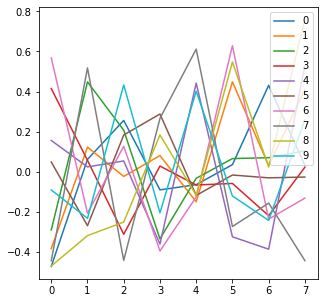

In [22]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

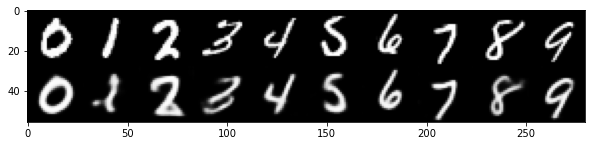

In [23]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [24]:
from XAE.sampler import gaus

exn = 5

In [25]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

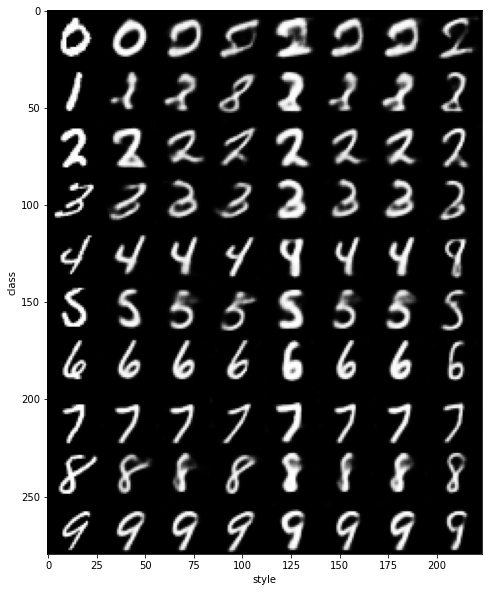

In [26]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [27]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

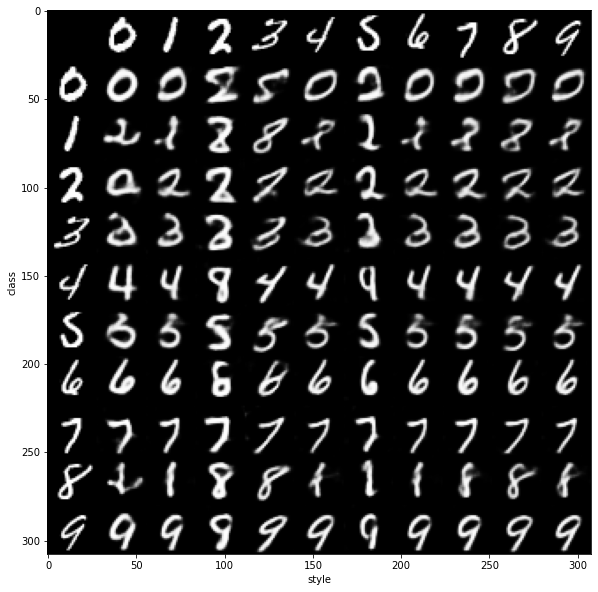

In [28]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()